### import libraries

In [1]:
from IPython.core.display import HTML
import os
import pandas as pd
from datetime import datetime
import re
import missingno as msno
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')


### Create Folder if not exist

In [2]:
if not os.path.exists('/Users/reka/Desktop/Data_in_the_Wild/data'):
    os.makedirs('/Users/reka/Desktop/Data_in_the_Wild/data')
if not os.path.exists('/Users/reka/Desktop/Data_in_the_Wild/figures'):
    os.makedirs('/Users/reka/Desktop/Data_in_the_Wild/figures')

### Navigate paths

In [3]:
data_path ="/Users/reka/Desktop/Data_in_the_Wild/data/"
style     ="/Users/reka/Desktop/Data_in_the_Wild/style/style.css"
fig = "/Users/reka/Desktop/Data_in_the_Wild/figures/"
HTML(open(style, 'r').read())

### Import and read the dataset

In [4]:
df = pd.read_csv(data_path+"out.csv")
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.sample(3)

,Type,Address,Price,Sqm Price,Size,Living Area,Ground Area,Rooms,Ownership Expense,Year Built,Story,Energy Label,Description,Longitude,Latitude,Cleaned_address
1942,Ejerlejlighed,"Vigerslevvej 65, st.. tv., 2500 Valby",-3%\n2.498.000 kr.,32.868 kr. / m²,Boligstørrelse: 76 m²,"Boligareal, tinglyst: 86 m²",NaN,Værelser: 3,Ejerudgift: 3.678 kr. / md.,Byggeår: 1929,st,Energimærke: D,"Vigerslevvej 65, st.. tv., 2500 Valby\nEjerlej...",12.486862,55.667189,Vigerslevvej 65 2500 Valby
4454,Ejerlejlighed,"Helmer Søgårds Alle 25, 2. th, 2770 Kastrup",2.645.000 kr.,40.075 kr. / m²,Boligstørrelse: 66 m²,"Boligareal, tinglyst: 73 m²",NaN,Værelser: 3,Ejerudgift: 3.112 kr. / md.,Byggeår: 1952,Sal: 2.,Energimærke: D,"Helmer Søgårds Alle 25, 2. th, 2770 Kastrup\nE...",12.643401,55.631927,Helmer Søgårds Alle 25 2770 Kastrup
1624,Ejerlejlighed,"Monica Zetterlunds Vej 17, st.. th., 2450 Købe...",-10%\n5.150.000 kr.,48.584 kr. / m²,Boligstørrelse: 106 m²,"Boligareal, tinglyst: 95 m²",NaN,Værelser: 3,Ejerudgift: 3.962 kr. / md.,Byggeår: 2019,st,Energimærke: A15,"Monica Zetterlunds Vej 17, st.. th., 2450 Købe...",NaN,NaN,Monica Zetterlunds Vej 17 2450 København SV


### Check the number of the NaN Values

In [5]:
print(" \nCount total NaN at each column in a DataFrame : \n\n",df.isnull().sum())



 
Count total NaN at each column in a DataFrame : 

 Type                    0
Address                 0
Price                   0
Sqm Price              49
Size                   49
Living Area          3227
Ground Area          3932
Rooms                  54
Ownership Expense      94
Year Built             71
Story                   0
Energy Label          372
Description             0
Longitude            1412
Latitude             1412
Cleaned_address         0
dtype: int64


<AxesSubplot:>

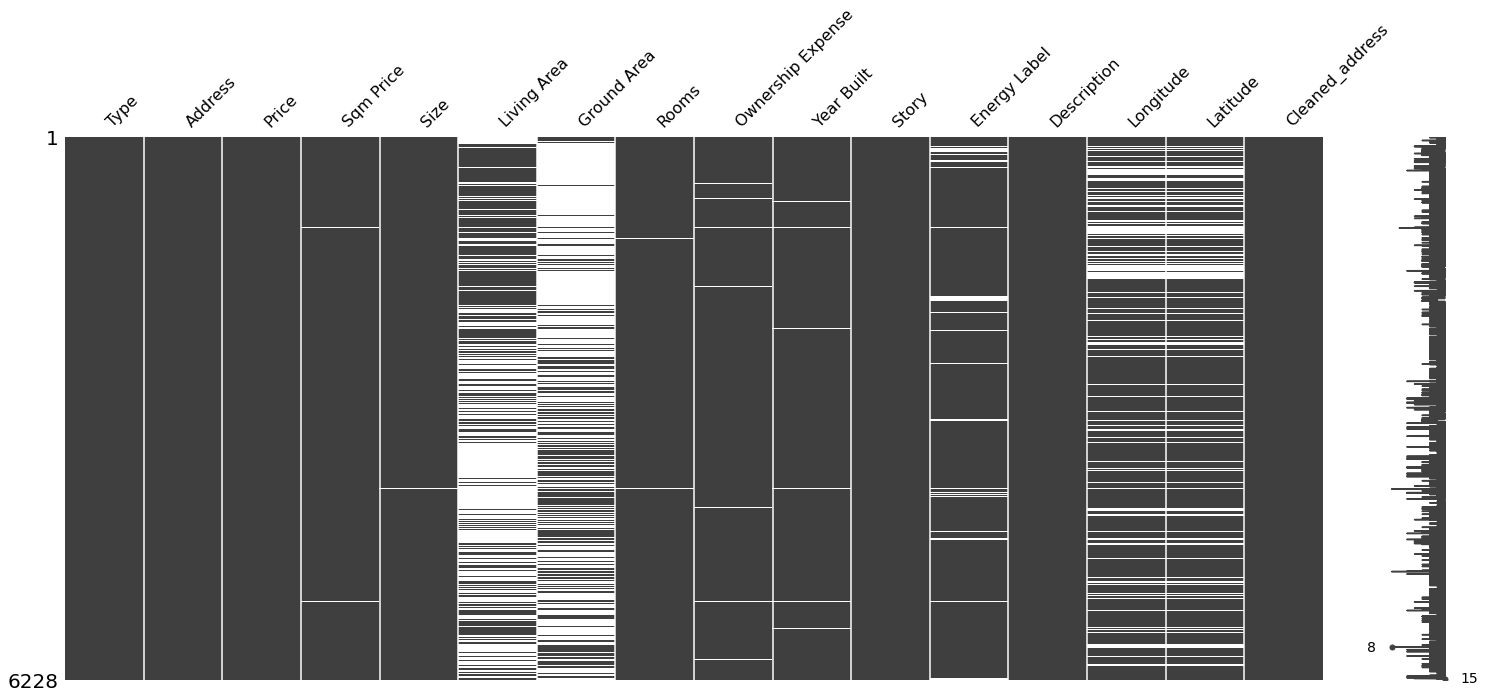

In [6]:
overview = msno.matrix(df)
plt.savefig(fig+"Missing_Values.png")#, overview)
overview

# Data Cleaning

In [7]:
df["Ground Area"] = df["Ground Area"].str.replace("\D","")
df["Size"] = df["Size"].str.replace("\D","")
df["Year Built"] = df["Year Built"].str.replace("\D","")

df["zp"]=df["Address"].str.split(",").str[-1].str.extract(r'(\d{4})')
df["ZipCode"]=df['Address'].str.extract(r'(\d{4})')

df["Living Area"] = df["Living Area"].str.replace(r"[^0-9.]","")

#Keep all after : at Room,Energy Label Columns
df["Rooms"] = df["Rooms"].str.replace("^(.*:)","")
df["Rooms"] = df["Rooms"].fillna(0)
df["Rooms"] = df["Rooms"].astype(int)

df["Energy Label"] = df["Energy Label"].str.replace("^(.*:)","")

df["Size"] = df["Size"].fillna(0)
df["Size"] = df["Size"].astype(int)


#Remove Everything from Ownership Expense's column except numerics and dot between numbers
df["Ownership Expense"] = df["Ownership Expense"].str.replace("(?<![\\d])\\.(?![\\d]+)","")
df["Ownership Expense"] = df["Ownership Expense"].str.replace(r"[^0-9.]","")

df["Sqm Price"] = df["Sqm Price"].str.replace("(?<![\\d])\\.(?![\\d]+)","")
df["Sqm Price"] = df["Sqm Price"].str.replace(r"[^0-9.]","")
#Remove all before ":" character , remove dots and replace groun floor(st) with 0 for Story Column
df["Story"] = df["Story"].str.replace("^(.*:)","")
df["Story"] = df["Story"].str.replace(".","")
df["Story"] = df["Story"].str.replace("st","0") 

#Find The Drop Rates by "%" character and assign NaN values as 0
df["Drop_Rate"] = df["Price"].str.findall(".*%\n").str[0]
df["Drop_Rate"] = df["Drop_Rate"].str.replace(r"[^0-9.]","")
df["Drop_Rate"] = df["Drop_Rate"].fillna(0)


#Remove all before character "\n" and keep dots between numbers
df["Price"] = df["Price"].str.replace("^(.*\n)","")
df["Price"] = df["Price"].str.replace("(?<![\\d])\\.(?![\\d]+)","")
df["Price"] = df["Price"].str.replace(r"[^0-9.]","")


#Convert NaN Year Built Column into 0
#Convert data type into int format
df = df[df['Year Built'].notna()]
df["Year Built"] = df["Year Built"].astype(int)
currentYear = datetime.now().year
df["Age of Building"] = currentYear - df["Year Built"]




### Calculate Price with Discount Percentage

In [8]:
def Calc():
    #Remove all excep digits
    df["remove"]=df["Price"].str.replace(r"[^0-9]","")
    df["remove"]=df["remove"].astype(int)
    df["Drop_Rate"] = df["Drop_Rate"].astype(int)
    """
    Price with Drop_Rate = (Price-(Price/100))
    """
    calc = df["remove"] - (df["remove"] * ((df["Drop_Rate"])/100))
    calc = calc.astype(int)
    del df["remove"]
    return calc

df["Price_W_Drop_Rate"] = Calc()
df["Price_W_Drop_Rate"]=df["Price_W_Drop_Rate"].astype(str)
df["Price_W_Drop_Rate"] = [re.sub(r'(\d\d\d)(?!$)',r'\1.',s[::-1])[::-1] for s in df["Price_W_Drop_Rate"]]


### Annotate Dataset with corresponding Towns

In [9]:
#Label dataset with town names

##  'HÃ¸je Taastrup',
string_lst = ['København K','København Nv','København V','København S','København N','København Ø','Vanløse',
              'Valby', 'Brønshøj', 'Nordhavn','Charlottenlund','Søborg','Dragør','Kongens Lyngby',
              'Solrød Strand','Hellerup','Glostrup','Bagsværd','Kastrup','Hvidovre','Hedehusene','Vedbæk',
              'Skovlunde','Ballerup','Solrød Strand','Virum','Nivå','Dyssegård','Albertslund','Nærum',
              'Skodsborg Strandvej','Brøndby Strand','Rungsted Kyst','Klampenborg','Rødovre','Vallensbæk',
              'Smørum','Ishøj','Skodsborg','Kokkedal','Herlev','Frederiksberg','Måløv','Christianshus',
              'Karlslunde','Nærheden','Tuborg Strandeng']


#string_lst =set(string_lst)
regex = re.compile("(?=(" + "|".join(map(re.escape, string_lst)) + "))")
town_list = [] 
for x  in df["Address"]:
    town_list.append(re.findall(regex,x))

df['Town'] = town_list
df['Town']= df['Town'].astype(str).str.replace("[","").str.replace("]","").str.replace("'","")
df['Town']= df['Town'].str.replace(",[^,]*$","")



In [10]:
Town = df.groupby(["Town"])["Town"].count().reset_index(name="Total").sort_values('Total', ascending=False)
Town.style.background_gradient(cmap="Wistia")#(cmap='Wistia')#(cmap='Reds')

,Town,Total
24,København S,716
0,,710
26,København Ø,309
22,København K,268
10,Frederiksberg,238
15,Hvidovre,213
5,Brønshøj,212
18,Kastrup,212
21,Kongens Lyngby,205
23,København N,200


### Check the number of Town

In [11]:

Towns = df.groupby(["Town"]).size().sort_values(ascending=False).reset_index(name="Out")
Towns["Out"].sum()

6157

## Remove Unnecessary Columns

In [12]:
del df["Address"]
del df["Description"]
del df["Cleaned_address"]
del df["zp"]

# Final Version of Data

In [13]:
df.sample(3)


,Type,Price,Sqm Price,Size,Living Area,Ground Area,Rooms,Ownership Expense,Year Built,Story,Energy Label,Longitude,Latitude,ZipCode,Drop_Rate,Age of Building,Price_W_Drop_Rate,Town
5033,Villa,31.500.000,100.961,312,NaN,1478,9,8.847,1957,0,B,12.506783,55.812060,2840,0,65,31.500.000,
3570,Rækkehus,3.375.000,28.601,118,NaN,NaN,4,2.649,1980,0,A10,12.292676,55.586208,2670,1,42,3.341.250,
5800,Ejerlejlighed,2.745.000,46.525,59,53,NaN,2,3.091,1935,2,D,12.574294,55.821295,2942,7,87,2.552.850,Skodsborg Strandvej


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6157 entries, 0 to 6227
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Type               6157 non-null   object 
 1   Price              6157 non-null   object 
 2   Sqm Price          6157 non-null   object 
 3   Size               6157 non-null   int64  
 4   Living Area        2982 non-null   object 
 5   Ground Area        2245 non-null   object 
 6   Rooms              6157 non-null   int64  
 7   Ownership Expense  6066 non-null   object 
 8   Year Built         6157 non-null   int64  
 9   Story              6157 non-null   object 
 10  Energy Label       5839 non-null   object 
 11  Longitude          4756 non-null   float64
 12  Latitude           4756 non-null   float64
 13  ZipCode            6157 non-null   object 
 14  Drop_Rate          6157 non-null   int64  
 15  Age of Building    6157 non-null   int64  
 16  Price_W_Drop_Rate  6157 

In [15]:
df.isnull().sum()

Type                    0
Price                   0
Sqm Price               0
Size                    0
Living Area          3175
Ground Area          3912
Rooms                   0
Ownership Expense      91
Year Built              0
Story                   0
Energy Label          318
Longitude            1401
Latitude             1401
ZipCode                 0
Drop_Rate               0
Age of Building         0
Price_W_Drop_Rate       0
Town                    0
dtype: int64

# Store The Cleaned data

In [16]:

df.to_csv(data_path+"Cleaned_data.csv",index = False)
